# ARIMA models analysis using RNN and LSTM

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scs

# my utils library
from ts_utils import stationary_check

plt.rcParams['figure.figsize'] = 15, 6

In [14]:
def tsplot(data, lags, show=True):

    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    with plt.style.context('bmh'):

        layout = (3, 2)

        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        prob_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title('Time plot for the data')

        smt.graphics.plot_acf(data, ax=acf_ax, lags=lags, alpha=0.5)
        # acf_ax.axhline(y=-1.96/np.sqrt(int(len(data))), linestyle='--')
        # acf_ax.axhline(y=1.96/np.sqrt(int(len(data))), linestyle='--')

        smt.graphics.plot_pacf(data, ax=pacf_ax, lags=lags, alpha=0.5)
        # acf_ax.axhline(y=-1.96/np.sqrt(int(len(data))), linestyle='--')
        # acf_ax.axhline(y=1.96/np.sqrt(int(len(data))), linestyle='--')

        [ax.set_ylim(-0.5, 1) for ax in [acf_ax, pacf_ax]]

        sm.qqplot(data, ax=qq_ax, line='s')
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=prob_ax)

#         plt.tight_layout()
        if show:
            plt.show()
    return

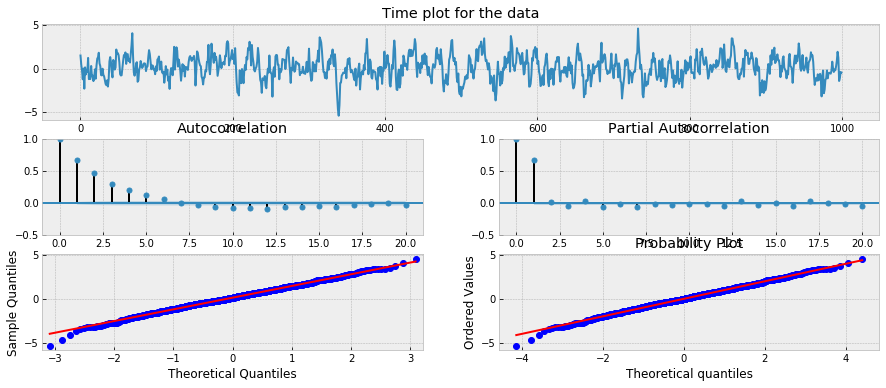

In [15]:
np.random.seed(1)
n_samples = 1000
data = noise = np.random.normal(size=1000)

# ar(1) model : x[t] = alpha * x[t-1] + noise

# case : 1, alpha = 0.5
alpha = 0.7
for t in range(len(data)):
    data[t] = alpha * data[t-1] + noise[t]

tsplot(data, lags=20, show=True)

In [6]:
stationary_check(data)

Fuller Stationarity check..
Fuller Statistics : -13.7935285690739
Fuller test P-value : 8.835653022152527e-26
#lags used : 0
#observation used: 999
Significance Level and value: 1%, : -3.4369127451400474
Significance Level and value: 5%, : -2.864437475834273
Significance Level and value: 10%, : -2.568312754566378
